In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error


from supplemental_english import REGION_CODES, GOVERNMENT_CODES


In [73]:
df = pd.read_csv('train.csv')
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51635 entries, 0 to 51634
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51635 non-null  int64 
 1   plate   51635 non-null  object
 2   date    51635 non-null  object
 3   price   51635 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.6+ MB
None


,id,plate,date,price
0,1,X059CP797,2024-12-26 00:00:00,65000
1,2,Y800MH790,2024-07-12 21:31:37,100000
2,3,A212TX77,2024-04-18 00:00:00,290000
3,4,P001AY199,2025-01-03 00:27:15,680000
4,5,P001AY199,2025-01-10 09:32:41,750000
5,6,B400BB750,2022-04-09 00:00:00,50000
6,7,P666OM790,2024-11-14 00:00:00,300000
7,8,C080KP777,2021-06-10 12:30:00,300000
8,9,E737AY550,2024-07-31 00:00:00,60000
9,10,C001KK750,2024-07-09 08:48:39,420000


In [74]:
region_codes_to_region = {}
for key, val in REGION_CODES.items():
    if type(val) == list:
        for v in val:
            region_codes_to_region[v] = key
    else:
        region_codes_to_region[val] = key
        
def get_region(plate):
    region_code = plate[6:]
    if region_codes_to_region[region_code]:
        return region_codes_to_region[region_code]
    else:
        return np.nan 

def get_government(plate):
    num_range = int(plate[1:4])
    letters = plate[0] + plate[4:6]
    regionCodes = plate[6:]
    
    for key, value in GOVERNMENT_CODES.items():
        key_letter, (start, end), key_region = key
        if letters == key_letter and regionCodes == key_region and int(start) <= num_range <= int(end):
            return value
    return (np.nan, np.nan, np.nan, np.nan)

df["region"] = df["plate"].apply(get_region)
df[['text', 'forbidenToBuy', 'advantageOnRoad', 'significance']] = df['plate'].apply(get_government).apply(pd.Series)

df.drop("text", axis=1, inplace=True)
df.isnull().sum()

id                     0
plate                  0
date                   0
price                  0
region                 0
forbidenToBuy      50973
advantageOnRoad    50973
significance       50973
dtype: int64

In [75]:
df.drop("id", axis=1, inplace=True)
df.fillna(0, inplace=True) # Most of the newly added columns have NaN values, we will replace it with 0, since they are mostly binary and categorical(significance)

df["date"] = df["date"].astype('datetime64[ns]')
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.dayofweek
df.drop("date", axis=1, inplace=True)

df["same_number_first"] = df["plate"].apply(lambda x: x[1] == x[2] == x[3])
df["same_number_second"] = df["plate"].apply(lambda x: x[6] == x[7] == x[8] if len(x) == 9 else x[6] == x[7])
df["matching_numbers"] = df["plate"].apply(lambda x: x[1:4] == x[6:])
df["palindrom_numbers_first"] = df["plate"].apply(lambda x: x[1:4] == x[1:4][::-1])
df["palindrom_numbers_second"] = df["plate"].apply(lambda x: x[6:] == x[6:][::-1])
df["palidrom_all_numbers"] = df["plate"].apply(lambda x: x[1:4] + x[6:] == str(x[1:4] + x[6:])[::-1])


In [77]:
df["plate"] = df["plate"].astype('category')
df["region"] = df["region"].astype('category')
df["forbidenToBuy"] = df["forbidenToBuy"].astype('bool')
df["advantageOnRoad"] = df["advantageOnRoad"].astype('bool')
df["significance"] = df["significance"].astype('int')
df["year"] = df["year"].astype('int')
df["month"] = df["month"].astype('int')
df["day"] = df["day"].astype('int')
df["day_of_week"] = df["day_of_week"].astype('int')
df["same_number_first"] = df["same_number_first"].astype('bool')
df["same_number_second"] = df["same_number_second"].astype('bool')
df["matching_numbers"] = df["matching_numbers"].astype('bool')
df["palindrom_numbers_first"] = df["palindrom_numbers_first"].astype('bool')
df["palindrom_numbers_second"] = df["palindrom_numbers_second"].astype('bool')
df["palidrom_all_numbers"] = df["palidrom_all_numbers"].astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51635 entries, 0 to 51634
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   plate                     51635 non-null  category
 1   price                     51635 non-null  int64   
 2   region                    51635 non-null  category
 3   forbidenToBuy             51635 non-null  bool    
 4   advantageOnRoad           51635 non-null  bool    
 5   significance              51635 non-null  int64   
 6   year                      51635 non-null  int64   
 7   month                     51635 non-null  int64   
 8   day                       51635 non-null  int64   
 9   day_of_week               51635 non-null  int64   
 10  same_number_first         51635 non-null  bool    
 11  same_number_second        51635 non-null  bool    
 12  matching_numbers          51635 non-null  bool    
 13  palindrom_numbers_first   51635 non-null  bool

In [78]:
df

,plate,price,region,forbidenToBuy,advantageOnRoad,significance,year,month,day,day_of_week,same_number_first,same_number_second,matching_numbers,palindrom_numbers_first,palindrom_numbers_second,palidrom_all_numbers
0,X059CP797,65000,Moscow,False,False,0,2024,12,26,3,False,False,False,False,True,False
1,Y800MH790,100000,Moscow Oblast,False,False,0,2024,7,12,4,False,False,False,False,False,False
2,A212TX77,290000,Moscow,False,False,0,2024,4,18,3,False,True,False,True,True,False
3,P001AY199,680000,Moscow,False,False,0,2025,1,3,4,False,False,False,False,False,False
4,P001AY199,750000,Moscow,False,False,0,2025,1,10,4,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51630,X023PP797,70000,Moscow,False,False,0,2025,1,29,2,False,False,False,False,True,False
51631,M004KA161,1600000,Rostov Oblast,False,False,0,2025,1,31,4,False,False,False,False,True,False
51632,E888EB199,850000,Moscow,False,False,0,2025,2,6,3,True,False,False,True,False,False
51633,X023XK77,150000,Moscow,False,False,0,2024,4,24,2,False,True,False,False,True,False


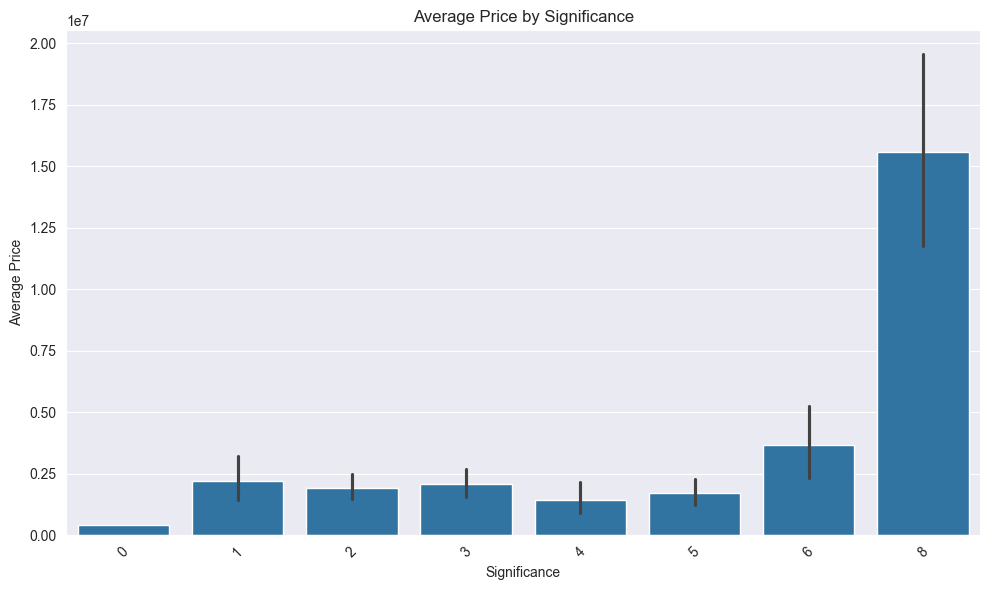

In [79]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='significance', y='price', estimator='mean')
plt.title('Average Price by Significance')
plt.xlabel('Significance')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

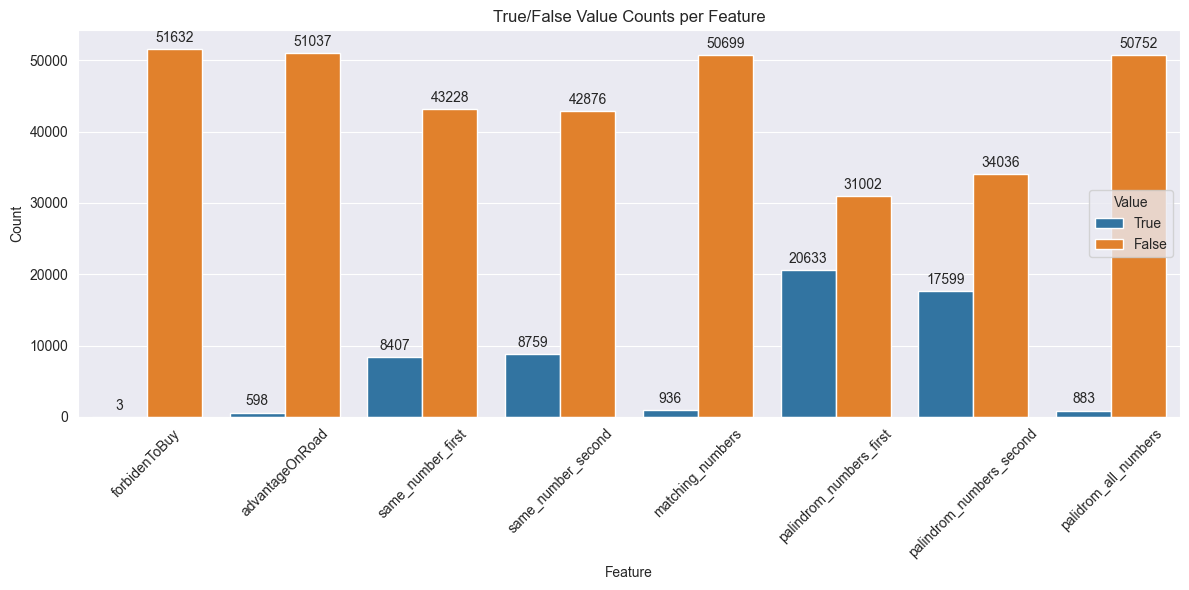

In [81]:
columns = [
    "forbidenToBuy", "advantageOnRoad", "same_number_first", "same_number_second",
    "matching_numbers", "palindrom_numbers_first", "palindrom_numbers_second", "palidrom_all_numbers"
]

data = []
for col in columns:
    true_count = df[col].sum()
    false_count = (~df[col]).sum()  # or len(df) - true_count
    data.append({"Feature": col, "Value": "True", "Count": true_count})
    data.append({"Feature": col, "Value": "False", "Count": false_count})

dftest = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=dftest, x='Feature', y='Count', hue='Value')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)
plt.xticks(rotation=45)
plt.title("True/False Value Counts per Feature")
plt.tight_layout()
plt.show()

In [61]:
dftest

,Feature,Value,Count
0,forbidenToBuy,True,3
1,forbidenToBuy,False,51632
2,advantageOnRoad,True,598
3,advantageOnRoad,False,51037
4,same_number_first,True,8407
5,same_number_first,False,43228
6,same_number_second,True,51635
7,same_number_second,False,0
8,matching_numbers,True,936
9,matching_numbers,False,50699


In [54]:
print(list(df["forbidenToBuy"]))

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

# Predikce

In [29]:
X = df.copy()
y = X["price"]
X.drop("price", axis=1, inplace=True)
X.drop("plate", axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=666)

In [30]:
print(f"Size train - X: {X_train.shape}, y: {y_train.shape}")
print(f"Size val - X: {X_val.shape}, y: {y_val.shape}")
print(f"Size test - X: {X_test.shape}, y: {y_test.shape}")

Size train - X: (41308, 5), y: (41308,)
Size val - X: (5163, 5), y: (5163,)
Size test - X: (5164, 5), y: (5164,)


## Nearesst Neighbours

In [31]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [33]:
predicted = neigh.predict(X_val)
root_mean_squared_error(y_val, predicted)

2747050.0779242674

## Hist Gradient Boosting

In [34]:
from sklearn.ensemble import HistGradientBoostingRegressor
est = HistGradientBoostingRegressor().fit(X_train, y_train)

In [36]:
pred = est.predict(X_val)
root_mean_squared_error(y_val, pred)

2734423.6233626874

## Gradient Boosting

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
est = GradientBoostingRegressor().fit(X_train, y_train)

pred = est.predict(X_val)
root_mean_squared_error(y_val, pred)

2734195.725571851

In [38]:
est.feature_importances_

array([3.60240532e-04, 5.92718964e-03, 7.23087231e-01, 1.57701354e-01,
       1.12923985e-01])

In [39]:
X_train

,forbidenToBuy,advantageOnRoad,significance,year,month
49519,0,0,0,2023,2
38768,0,0,0,2024,6
37756,0,0,0,2024,3
36886,0,0,0,2022,6
22986,0,0,0,2024,5
...,...,...,...,...,...
43422,0,0,0,2024,12
41030,0,0,0,2025,2
2878,0,0,0,2024,7
40365,0,0,0,2023,12


## Random Foreest

In [46]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
est = RandomForestRegressor().fit(X_train, y_train)

pred = est.predict(X_val)
root_mean_squared_error(y_val, pred)

2733304.8238625186

## AdaBoost

In [50]:
from sklearn.ensemble import AdaBoostClassifier
est = AdaBoostClassifier().fit(X_train, y_train)

pred = est.predict(X_val)
root_mean_squared_error(y_val, pred)

2794721.1269467263

## XGBoost

In [89]:
import xgboost as xgb
from xgboost import XGBRegressor

In [56]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [68]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror'}
param['evals'] = 'rmse'

evallist = [(dtrain, 'train'), (dval, 'eval')]

In [93]:
model = XGBRegressor(eval_metric="rmse")
model.fit(X_train, y_train, verbose=10)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [94]:
pred = model.predict(X_val)
root_mean_squared_error(y_val, pred)

2736664.75

In [81]:
pred_s = pd.Series(pred)

In [83]:
y_val

35045     250000
16523      50000
23441     950000
3458     2850000
33151      50000
          ...   
42442     170000
37208      30000
27420     320000
9987      400000
51585     300000
Name: price, Length: 5163, dtype: int64

In [87]:
pred_s

0       330891.625000
1       467945.000000
2       467945.000000
3       550317.750000
4       339656.437500
            ...      
5158    264208.156250
5159    257283.671875
5160    467945.000000
5161    517315.093750
5162    541552.937500
Length: 5163, dtype: float32

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

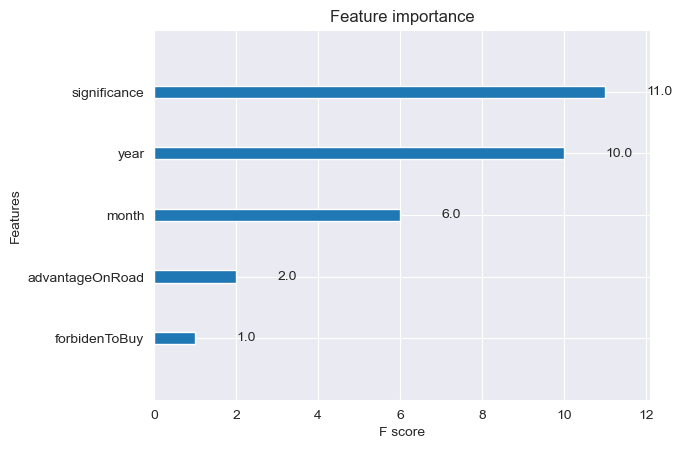

In [72]:
xgb.plot_importance(bst)